# Where does received level decrease come from for SMP mics?
I attached the SMP mic to a cardboard sheet and aligned it to a Polaroid speaker. See [Calibration docs](april2021-mic-calibrations.md). 

I observed a reduction in received level as the speaker was more off-axis. My question: is this because of the background (the sheet/'wall') or is it actually the mics directionality that I'm seeing. 

To answer this I first recorded sounds at 0-90degrees. Then I created a 'pseudo-90' degrees position, where I set the turntable to 90deg but made the microphone face the speaker. If there is no effect of the wall on playback level, then the pseudo-90 degrees should have the same received level as the 0 degrees. Let's see if this is true. 

In [1]:
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy.signal as signal 
import soundfile as sf

In [2]:
%matplotlib notebook

In [3]:
fs = 192000
b,a = signal.butter(2,5000/fs*0.5,'high')
highpass = lambda X: signal.filtfilt(b,a,X)
dB = lambda X : 20*np.log10(abs(X))
dbrms = lambda X: dB(np.sqrt(np.mean(X**2.0)))

In [4]:
wavfiles = glob.glob('2021-04-15/*.wav')+glob.glob('2021-04-16/*.wav')
wavfiles

['2021-04-15\\SMP1_gaindB_30_azimuth_angle_0_2021-04-15_18-56-27.wav',
 '2021-04-15\\SMP1_gaindB_30_azimuth_angle_30_2021-04-15_18-57-21.wav',
 '2021-04-15\\SMP1_gaindB_30_azimuth_angle_60_2021-04-15_18-58-03.wav',
 '2021-04-15\\SMP1_gaindB_30_azimuth_angle_90_2021-04-15_18-58-48.wav',
 '2021-04-15\\SMP1_gaindB_30_azimuth_angle_pseudo90_2021-04-15_19-01-44.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_0_2021-04-16_15-36-15.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_0_2021-04-16_18-04-42.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_0_2021-04-16_18-12-02.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_0_2021-04-16_18-14-35.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_0_2021-04-16_18-15-35.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_0_2021-04-16_18-21-06.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_30_2021-04-16_18-05-19.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_30_2021-04-16_18-22-33.wav',
 '2021-04-16\\SMP1_gaindB_30_azimuth_angle_60_2021-04-16_18-05-51

In [5]:
for each in wavfiles:
    print(sf.info(each).duration)

18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0
18.0


All files have the same duration - which means we can just compare the dB rms of all files after highpassing. 

In [6]:
half_durn = 9 # secs
half_durnsamples = int(half_durn*fs)
sweeps_section = int(1.5*fs)
audio_hp = []
tones_dbrms = []
audio_dbrms1half = []
audio_dbrms2half = []
sweeps_dbrms = []
silence_dbrms = []
tones_dbrms = []
for each in wavfiles:
    audio,fs = sf.read(each)
    highpassed = highpass(audio)
    audio_hp.append(highpassed)
    tones_dbrms.append(dbrms(highpassed[int(1.5*fs):]))
    audio_dbrms1half.append(dbrms(highpassed[int(1.5*fs):half_durnsamples]))
    audio_dbrms2half.append(dbrms(highpassed[half_durnsamples:]))
    sweeps_dbrms.append(dbrms(highpassed[int(0.5*fs):sweeps_section]))
    silence_dbrms.append(dbrms(highpassed[:int(0.5*fs)]))

In [7]:
wavfiles;

In [8]:
angles = [each.split('_')[5] for each in wavfiles]

In [9]:
plt.figure(figsize=(8,8))
plt.plot(tones_dbrms,'-*',label='tones')
plt.plot(audio_dbrms1half,'-*',label='1st half')
plt.plot(audio_dbrms2half,'-*',label='2nd half')
plt.plot(sweeps_dbrms,'-*',label='sweeps')
plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-60,-30);plt.yticks(np.arange(-60,-28,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Orientation to speaker')
plt.savefig('imgs/no-board-effect.jpg')

<IPython.core.display.Javascript object>

The received level at pseudo-90 is very close to that at 0 or 30 degrees. This tells me that the 'wall' itself is not blocking/collecting sound to the microphone. 

However, it is important to note that for one position, there is a very large discrepancy - pseudo60, where the difference between on-axis and measured is ~4dB! This is much larger than the max 2dB seen for other positions. 


### The situation is a bit unclear ....

## Re-analysis with time-sorted ordering 

In [10]:
rec_levels = pd.DataFrame(data={'filepaths':wavfiles, 'tones_level':tones_dbrms,
                                'first_half':audio_dbrms1half, 'second_half': audio_dbrms2half,
                                'sweeps_level': sweeps_dbrms})

In [11]:
def extract_md_hhmmss(fname):
    
    ymd, time_wav = fname.split('_')[-2:]
    md = ymd[5:]
    only_time = time_wav[:-4]
    return md + ',' + only_time
def extract_angle(fname):
    angle_value = fname.split('_')[5]
    return angle_value

In [13]:
rec_levels['filename'] = rec_levels['filepaths'].apply(lambda X: os.path.split(X)[-1])
rec_levels['rec_time'] = rec_levels['filename'].apply(extract_md_hhmmss)
rec_levels['angle'] = rec_levels['filename'].apply(extract_angle)
rec_levels = rec_levels.sort_values('rec_time')


In [14]:
rec_levels

,filepaths,tones_level,first_half,second_half,sweeps_level,filename,rec_time,angle
0,2021-04-15\SMP1_gaindB_30_azimuth_angle_0_2021...,-36.244792,-35.632408,-36.830638,-49.118648,SMP1_gaindB_30_azimuth_angle_0_2021-04-15_18-5...,"04-15,18-56-27",0
1,2021-04-15\SMP1_gaindB_30_azimuth_angle_30_202...,-37.083982,-36.423952,-37.722759,-49.961894,SMP1_gaindB_30_azimuth_angle_30_2021-04-15_18-...,"04-15,18-57-21",30
2,2021-04-15\SMP1_gaindB_30_azimuth_angle_60_202...,-42.756811,-41.442360,-44.272142,-55.721681,SMP1_gaindB_30_azimuth_angle_60_2021-04-15_18-...,"04-15,18-58-03",60
3,2021-04-15\SMP1_gaindB_30_azimuth_angle_90_202...,-44.237105,-43.389130,-45.097285,-56.907437,SMP1_gaindB_30_azimuth_angle_90_2021-04-15_18-...,"04-15,18-58-48",90
4,2021-04-15\SMP1_gaindB_30_azimuth_angle_pseudo...,-36.966695,-37.223083,-36.764026,-49.870654,SMP1_gaindB_30_azimuth_angle_pseudo90_2021-04-...,"04-15,19-01-44",pseudo90
23,2021-04-16\SMP1_gaindB_30_azimuth_angle_pseudo...,-37.289362,-37.501796,-37.119942,-50.168025,SMP1_gaindB_30_azimuth_angle_pseudo90_2021-04-...,"04-16,15-32-53",pseudo90
20,2021-04-16\SMP1_gaindB_30_azimuth_angle_pseudo...,-38.903462,-42.479741,-37.237451,-51.527258,SMP1_gaindB_30_azimuth_angle_pseudo60_2021-04-...,"04-16,15-34-22",pseudo60
16,2021-04-16\SMP1_gaindB_30_azimuth_angle_pseudo...,-37.388239,-36.333928,-38.517544,-51.086454,SMP1_gaindB_30_azimuth_angle_pseudo30_2021-04-...,"04-16,15-35-17",pseudo30
5,2021-04-16\SMP1_gaindB_30_azimuth_angle_0_2021...,-38.004021,-38.619734,-37.550199,-50.718346,SMP1_gaindB_30_azimuth_angle_0_2021-04-16_15-3...,"04-16,15-36-15",0
19,2021-04-16\SMP1_gaindB_30_azimuth_angle_pseudo...,-41.886033,-41.817700,-41.943810,-56.836468,SMP1_gaindB_30_azimuth_angle_pseudo60-2_2021-0...,"04-16,17-53-51",pseudo60-2


<IPython.core.display.Javascript object>


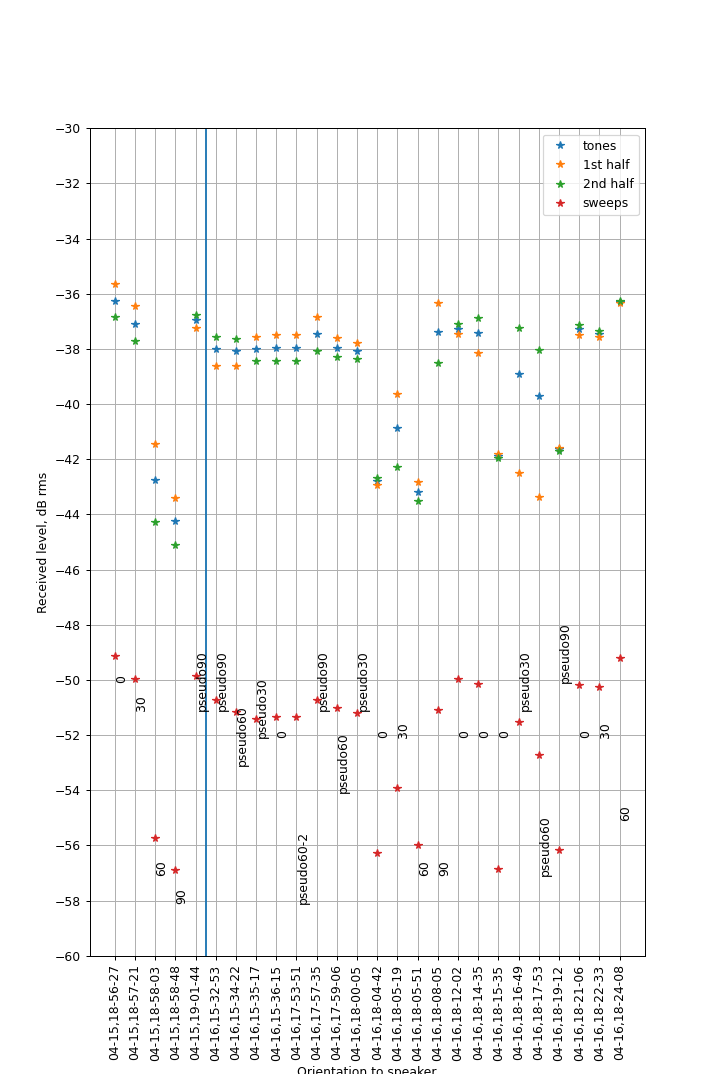

Text(0.5, 0, 'Orientation to speaker')

In [26]:
plt.figure(figsize=(8,12))
plt.plot(rec_levels['tones_level'],'*',label='tones')
plt.plot(rec_levels['first_half'],'*',label='1st half')
plt.plot(rec_levels['second_half'],'*',label='2nd half')
plt.plot(rec_levels['sweeps_level'],'*',label='sweeps')
plt.vlines(4.5,-30,-60)
for i,(theta, each) in enumerate(zip(rec_levels['angle'],rec_levels['sweeps_level'])):
    plt.text(i,np.round(each)-1, theta, rotation=90)

plt.xticks(range(len(wavfiles)),rec_levels['rec_time'],rotation=90,fontsize=10);
plt.legend()
plt.ylim(-60,-30);plt.yticks(np.arange(-60,-28,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Orientation to speaker')

#plt.savefig('imgs/no-board-effect.jpg')

### There seems to be a decent amount of playback-2-playback variation!! 
I don't think there's that much labelling error. I can't have repeated labelling mistakes so many times, and so I suspect there is variation from the speaker side.... need to see where this is coming from with repeated playbacks across speakers. 

In [16]:
print(f'Notebook last run {dt.datetime.now()}')

Notebook last run 2021-04-21 14:39:11.226773
